In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import confusion_matrix, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

# The Why

Out of the two presentations I did for part one of the Capstone project, I opted to go for the health inspection scores provided by the City of Austin's Health & Human Services department.

My goal is to basically do a cluster map to pinpoint any organization that handles food, and has had a failing health score multiple times.  I have a few desirable elements and challengesfor this that I don't know how to do or handle yet, such as:

I'd like to do the clusters over an overlay of a map of Austin.

I have 3 years worth of data.  Not sure if that's too much.  To overcome the idea that it's too much, I can focus on just the failing scores and omit the passing scores.

The data clean up was pretty easy.  I'll outline various clean up chores I had to do as this Jupyter Notebook progresses.



In [34]:
#Bring in the file.
df=pd.read_csv("Restaurant_Inspection_Scores.csv") #delimiter="/")

In [35]:
#Check the head.
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID,Process Description
0,Tortilleria Rio Grande,78753,08/19/2015,81,"900 E BRAKER LN Unit 160\nAUSTIN, TX 78753\n(3...",10239712,Routine Inspection
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,"3028 ROGGE LN\nAUSTIN, TX 78723\n(30.303188, -...",10871599,Routine Inspection
2,WL - Eanes Elementary,78746,02/09/2015,100,"4101 BEE CAVES RD\nWEST LAKE HILLS, TX 78746\n...",10002740,Routine Inspection


In [36]:
#Check the shape.
df.shape

(25562, 7)

In [37]:
#Examine the description
df.describe()

,Score,Facility ID
count,25562.000000,2.556200e+04
mean,91.276465,7.735905e+06
std,7.508453,3.869482e+06
min,36.000000,2.800004e+06
25%,87.000000,2.802304e+06
50%,93.000000,1.022271e+07
75%,97.000000,1.092674e+07
max,100.000000,1.174516e+07


In [38]:
#Look at nulls.
df.isnull().sum()

Restaurant Name        0
Zip Code               0
Inspection Date        0
Score                  0
Address                0
Facility ID            0
Process Description    0
dtype: int64

# Clean up the Zip Code
I need to transform it from an object to an int.  Zip Code is important because I plan on deleting the Address column as the data in Address can be found in several other columns, namely Facility ID and Zip Code.

In [40]:
df.dtypes

Restaurant Name        object
Zip Code               object
Inspection Date        object
Score                   int64
Address                object
Facility ID             int64
Process Description    object
dtype: object

In [41]:
df.drop(["Address"], axis=1, inplace=True)
#Dropping address because I already have zip code, restaurant name and facility ID.

In [42]:
#I see Zip Code is kind of funky.  I'll need to clean Zip Code up.
#I actually found out Zip Code was funky when trying to change it from an object to an int.
df.sort_values(["Zip Code"], ascending=False)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
16541,MN - Market Express,as 78653,06/20/2017,92,11632199,Routine Inspection
10096,Circle A,Hwy 290 E\nAustin TX 78723,03/16/2016,76,2803780,Routine Inspection
9431,Circle A,Hwy 290 E\nAustin TX 78723,08/18/2015,90,2803780,Routine Inspection
10097,Circle A,Hwy 290 E\nAustin TX 78723,02/25/2015,82,2803780,Routine Inspection
9808,Circle A,Hwy 290 E\nAustin TX 78723,12/14/2016,97,2803780,Routine Inspection
9418,Circle A,Hwy 290 E\nAustin TX 78723,06/30/2017,90,2803780,Routine Inspection
18108,Mesa Mart,78759,04/29/2016,96,2804064,Routine Inspection
1966,Wendy's #W129/11274,78759,08/22/2017,88,11115872,Routine Inspection
18093,Marco's Pizza,78759,03/10/2015,97,10905433,Routine Inspection
1965,Walgreen's #04134,78759,05/13/2015,93,2803712,Routine Inspection


In [43]:
#Remove weird strings in Zip Code.  
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('6\nAustin, TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('Hwy 290 E\nAustin TX'))
df['Zip Code'] = df['Zip Code'].map(lambda x: x.lstrip('as'))

In [44]:
#Checking to see if it's clean.
df.sort_values(["Zip Code"], ascending=False)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
25561,Texadelphia,78759,08/02/2017,88,11625566,Routine Inspection
2460,Z'Tejas,78759,06/27/2017,82,11485790,Routine Inspection
16922,Luby's,78759,12/11/2014,92,2800051,Routine Inspection
2454,d'lites,78759,10/13/2016,98,11339373,Routine Inspection
16936,Mama Fu's Arboretum,78759,12/30/2014,100,11105525,Routine Inspection
16939,"Lighthouse, The",78759,06/20/2017,82,11191562,Routine Inspection
16978,Lexus of Austin,78759,11/03/2015,89,10626918,Routine Inspection
2434,Whole Foods Market,78759,02/01/2017,94,2803492,Routine Inspection
17016,Mama Fu's Arboretum,78759,04/08/2016,94,11105525,Routine Inspection
17038,Mama Fu's Arboretum,78759,05/02/2017,90,11105525,Routine Inspection


In [46]:
df["Zip Code"] = df["Zip Code"].apply(pd.to_numeric, errors='coerce')
# #Made it into a float, when I wanted an int.

In [47]:
df.head(3) #Checking to see if it visually looks correct.

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,Routine Inspection
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,Routine Inspection
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,Routine Inspection


In [48]:
df.dtypes  #Now checking to see if it is correct.  Says it's an int: mission accomplished.

Restaurant Name        object
Zip Code                int64
Inspection Date        object
Score                   int64
Facility ID             int64
Process Description    object
dtype: object

# Clean up the Process Description
 I want to transform the various process descriptions into dummies, so I can eventually use the groupby feature (possibly) or to break the data down into smaller bits so I can model it.

In [49]:
#(Make Process Description binary w/ get dummies.
df=pd.get_dummies(df, columns=["Process Description"])

In [50]:
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description_1st Follow Up to Routine of 49 or less,Process Description_1st Follow Up to Routine of 50 - 69,Process Description_2nd Follow Up to 50 - 69,Process Description_Routine Inspection
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,0,0,0,1
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,0,0,0,1
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,0,0,0,1


# Clean up the Inspection Date

Inspection date is a string.  I need to make it into an int.  I also want to split the dates up, as I might want to focus on specific years or months, or just have the data broken up so I can play with it.  

Maybe some years were more horrible for food inspection reports than others?  Or are there more failed food inspections as more restaurants enter into the review process?

In [51]:
#Break up the Inspection Date into 3 columns.
df["Month"]=df["Inspection Date"].map(lambda x: x.split("/")[0])
df["Year"]=df["Inspection Date"].map(lambda x: x.split("/")[2])
df["Day"]=df["Inspection Date"].map(lambda x: x.split("/")[1])

In [168]:
#Check the work.
df.head(3)

,Restaurant Name,Zip Code,Inspection Date,Score,Facility ID,Process Description_1st Follow Up to Routine of 49 or less,Process Description_1st Follow Up to Routine of 50 - 69,Process Description_2nd Follow Up to 50 - 69,Process Description_Routine Inspection,Day,Month,Year
0,Tortilleria Rio Grande,78753,08/19/2015,81,10239712,0,0,0,1,19,08,2015
1,Two Steps Ahead Learning Center,78723,04/02/2015,100,10871599,0,0,0,1,02,04,2015
2,WL - Eanes Elementary,78746,02/09/2015,100,10002740,0,0,0,1,09,02,2015


In [52]:
#I want to reorder the column names, but I want to see all the column names first.
df.columns

Index(['Restaurant Name', 'Zip Code', 'Inspection Date', 'Score',
       'Facility ID',
       'Process Description_1st Follow Up to Routine of 49 or less',
       'Process Description_1st Follow Up to Routine of 50 - 69',
       'Process Description_2nd Follow Up to 50 - 69',
       'Process Description_Routine Inspection', 'Month', 'Year', 'Day'],
      dtype='object')

In [53]:
#Let the re-ordering begin.
df = df[['Facility ID', 'Restaurant Name', 'Zip Code',
         'Month', 'Day','Year',
         'Process Description_1st Follow Up to Routine of 49 or less',
         'Process Description_1st Follow Up to Routine of 50 - 69',
         'Process Description_2nd Follow Up to 50 - 69', 
         'Process Description_Routine Inspection',
         'Inspection Date',
         'Score'        
          ]]

In [54]:
#Check the work.
df.head(3)

,Facility ID,Restaurant Name,Zip Code,Month,Day,Year,Process Description_1st Follow Up to Routine of 49 or less,Process Description_1st Follow Up to Routine of 50 - 69,Process Description_2nd Follow Up to 50 - 69,Process Description_Routine Inspection,Inspection Date,Score
0,10239712,Tortilleria Rio Grande,78753,08,19,2015,0,0,0,1,08/19/2015,81
1,10871599,Two Steps Ahead Learning Center,78723,04,02,2015,0,0,0,1,04/02/2015,100
2,10002740,WL - Eanes Elementary,78746,02,09,2015,0,0,0,1,02/09/2015,100


In [55]:
#Make my months, day and years into ints than strings.
df['Month'] = df['Month'].astype(str).astype(int)
df['Day'] = df['Day'].astype(str).astype(int)
df['Year'] = df['Year'].astype(str).astype(int)

In [56]:
#Check the work.
df.dtypes

Facility ID                                                    int64
Restaurant Name                                               object
Zip Code                                                       int64
Month                                                          int64
Day                                                            int64
Year                                                           int64
Process Description_1st Follow Up to Routine of 49 or less     uint8
Process Description_1st Follow Up to Routine of 50 - 69        uint8
Process Description_2nd Follow Up to 50 - 69                   uint8
Process Description_Routine Inspection                         uint8
Inspection Date                                               object
Score                                                          int64
dtype: object

# Data Exploration - in process!

In [57]:
df.groupby('Facility ID').count()

,Restaurant Name,Zip Code,Month,Day,Year,Process Description_1st Follow Up to Routine of 49 or less,Process Description_1st Follow Up to Routine of 50 - 69,Process Description_2nd Follow Up to 50 - 69,Process Description_Routine Inspection,Inspection Date,Score
Facility ID,,,,,,,,,,,
2800004,5,5,5,5,5,5,5,5,5,5,5
2800006,6,6,6,6,6,6,6,6,6,6,6
2800007,6,6,6,6,6,6,6,6,6,6,6
2800008,6,6,6,6,6,6,6,6,6,6,6
2800009,5,5,5,5,5,5,5,5,5,5,5
2800010,6,6,6,6,6,6,6,6,6,6,6
2800013,5,5,5,5,5,5,5,5,5,5,5
2800015,6,6,6,6,6,6,6,6,6,6,6
2800018,6,6,6,6,6,6,6,6,6,6,6


In [23]:
df.groupby("Process Description").count()

,Restaurant Name,Zip Code,Inspection Date,Score,Address,Facility ID
Process Description,,,,,,
1st Follow Up to Routine of 49 or less,2,2,2,2,2,2
1st Follow Up to Routine of 50 - 69,152,152,152,152,152,152
2nd Follow Up to 50 - 69,6,6,6,6,6,6
Routine Inspection,25402,25402,25402,25402,25402,25402


In [24]:
df.columns

Index(['Restaurant Name', 'Zip Code', 'Inspection Date', 'Score', 'Address',
       'Facility ID', 'Process Description'],
      dtype='object')

In [27]:
df.groupby("Score").count()

,Restaurant Name,Zip Code,Inspection Date,Address,Facility ID,Process Description
Score,,,,,,
36,1,1,1,1,1,1
45,2,2,2,2,2,2
50,4,4,4,4,4,4
51,1,1,1,1,1,1
53,5,5,5,5,5,5
54,5,5,5,5,5,5
55,3,3,3,3,3,3
56,6,6,6,6,6,6
57,6,6,6,6,6,6


In [31]:
df.notnull().count()

Restaurant Name        25562
Zip Code               25562
Inspection Date        25562
Score                  25562
Address                25562
Facility ID            25562
Process Description    25562
dtype: int64

In [33]:
corr=df.corr()

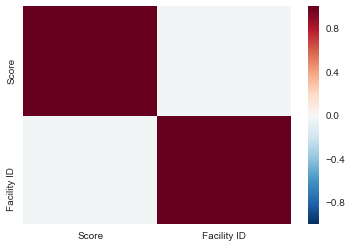

In [34]:
sns.heatmap(corr)

TypeError: string indices must be integers

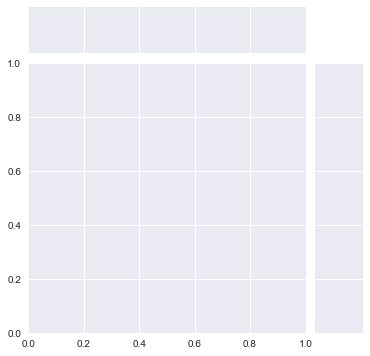

In [40]:
sns.jointplot(x='Score ', y='Process Description', data=df)